In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import xgboost as xgb
import pickle

In [19]:
data = pd.read_csv("data/diabetes.pssm.cv.csv", header=None)
print(data.shape)
print(data.columns)
data.head(3)

(10002, 401)
Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            391, 392, 393, 394, 395, 396, 397, 398, 399, 400],
           dtype='int64', length=401)


0         1         2         3         4         5         6    \
0  0.622449 -0.326531 -0.295918 -0.316327 -0.163265 -0.224490 -0.244898   
1  0.166667 -0.096491 -0.087719 -0.105263 -0.105263 -0.114035 -0.078947   
2  0.260870 -0.191304 -0.139130 -0.130435 -0.165217 -0.139130 -0.113043   

        7         8         9   ...        391       392       393       394  \
0 -0.081633 -0.336735 -0.285714 ...  -0.051020  0.010204 -0.040816 -0.051020   
1  0.000000 -0.140351 -0.096491 ...  -0.201754  0.017544 -0.035088 -0.149123   
2 -0.017391 -0.208696 -0.191304 ...  -0.147826  0.000000 -0.139130 -0.226087   

        395       396       397       398       399  400  
0 -0.030612  0.020408 -0.071429 -0.051020  0.091837    1  
1 -0.096491 -0.061403 -0.201754 -0.175439  0.219298    1  
2 -0.156522 -0.095652 -0.217391 -0.191304  0.260870    1  

[3 rows x 401 columns]

In [20]:
data_cols = data.columns[:-1]

print(data_cols)
print('# of data columns: ',len(data_cols))

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            390, 391, 392, 393, 394, 395, 396, 397, 398, 399],
           dtype='int64', length=400)
# of data columns:  400


In [21]:
data.groupby(400)[400].count()


400
0    7625
1    2377
Name: 400, dtype: int64

In [7]:
2377/(2377+7625)

0.23765246950609878

In [8]:
#test = data[400]
#test = [0 if t > 1 else 1 for t in test]
#data[400] = test

In [22]:
data.skew()

0       1.402965
1     -59.809454
2      -1.460451
3      -1.490728
4      44.942651
5      -1.247190
6       8.948535
7      -2.056805
8      -1.258057
9      -1.251465
10     -1.312709
11     -1.424206
12     -1.425001
13     -1.203348
14      2.364090
15     47.791146
16     -0.845703
17     -1.085373
18     -1.259692
19      6.631590
20     -1.360134
21      1.516854
22      6.600297
23     -1.361448
24     -1.145026
25    -18.560912
26     -2.072296
27     -0.963954
28      0.611795
29     -1.332813
         ...    
371    74.740114
372   -17.126283
373    81.672314
374    37.810543
375    18.511604
376   -83.168649
377    -0.850956
378     0.938042
379    -1.356605
380    -2.176895
381    -1.009300
382    -0.968017
383    -0.938645
384    72.056821
385    -1.042887
386    -1.010849
387    -7.314814
388    -0.957503
389     0.735831
390    12.321402
391    -1.014703
392    -0.279797
393   -72.214717
394    -0.876748
395    12.960668
396     4.139215
397    -0.838561
398    -1.1673

In [23]:
# Center and scale all data, only using the middle 99.8%, so outliers don't pull too much.
# First generate the percentile data for each feature

percentiles =  pd.DataFrame( np.array([ np.percentile( data[i], [ 0.1, 99.9 ] ) for i in data_cols ]).T,
                            columns=data_cols, index=['min','max'] )

percentile_means = \
    [ [ np.mean( data.loc[ (data[i]>percentiles[i]['min']) & (data[i]<percentiles[i]['max']) , i ] ) ]
     for i in data_cols ]

percentiles = percentiles.append( pd.DataFrame(np.array(percentile_means).T, columns=data_cols, index=['mean']) )

percentile_stds = \
    [ [ np.std( data.loc[ (data[i]>percentiles[i]['min']) & (data[i]<percentiles[i]['max']) , i ] ) ]
     for i in data_cols ]

percentiles = percentiles.append( pd.DataFrame(np.array(percentile_stds).T, columns=data_cols, index=['stdev']) )

percentiles

0         1         2         3         4         5         6    \
min    0.011232 -0.393327 -0.375795 -0.448900 -0.314045 -0.333333 -0.365314   
max    0.674400  0.006409  0.005764  0.000000  0.093301  0.046183  0.068269   
mean   0.201852 -0.107208 -0.096663 -0.118768 -0.072086 -0.069397 -0.074437   
stdev  0.083480  0.054772  0.052911  0.061517  0.050320  0.047993  0.052847   

            7         8         9      ...          390       391       392  \
min   -6.629448 -0.426424 -0.359145    ...    -0.068181 -0.433701 -5.783395   
max    0.173553  0.014493  0.023805    ...     0.185708  0.000000  5.209789   
mean  -0.031220 -0.122512 -0.096514    ...     0.034516 -0.138109  0.023051   
stdev  0.037340  0.059566  0.048205    ...     0.028351  0.065467  0.097858   

            393       394       395       396       397       398       399  
min   -0.249998 -0.474031 -0.333331 -7.097152 -0.502055 -0.327027  0.015505  
max    0.075061  0.029190  0.009850  8.525006  0.000000  0.011319  0.542852  
mean  -0.056778 -0.145705 -0.091101 -0.018690 -0.174550 -0.097648  0.191675  
stdev  0.038891  0.070765  0.049721  0.344073  0.067818  0.046387  0.073304  

[4 rows x 400 columns]

In [24]:
# Center and scale the data using the percentile data

data[data_cols] = ( data[data_cols] - percentiles.loc[ 'mean', data_cols ] ) / percentiles.loc[ 'stdev', data_cols ]


In [25]:
data

0         1         2         3         4         5         6    \
0      5.038271 -4.004272 -3.765826 -3.211471 -1.811984 -3.231574 -3.225593   
1     -0.421476  0.195669  0.169047  0.219530 -0.659315 -0.930097 -0.085351   
2      0.706968 -1.535374 -0.802599 -0.189659 -1.850776 -1.452985 -0.730539   
3      0.745001 -1.222313 -1.146061 -0.900393 -2.809963 -1.012255 -0.079768   
4      1.388409 -1.739638 -2.765528 -1.614215 -2.220095 -1.539914 -0.890474   
5      0.153772  0.822702 -0.415423  0.093857 -0.981375  0.327647  0.713642   
6      0.706968  0.171295 -0.227410  0.340424  0.136517  0.087091  0.791490   
7      0.027839  0.262929  0.116733  0.459725 -1.011205  0.334064  0.793874   
8     -0.083325 -0.245413  0.116733  0.120273 -0.042916  0.285724  0.135326   
9      0.717976  0.235507  0.628382  0.371164  0.301581  0.463458  0.547027   
10    -0.506742  0.506283  0.078177  0.127685  0.371733  0.296642  0.454552   
11     0.369703  0.510299  0.328956  0.066596 -0.879805  0.286453  0.706527   
12     0.291661  0.026130 -0.079974 -0.007075  0.486618  0.038793  0.207592   
13     1.998300 -1.451481 -1.133644 -1.052985 -3.661439 -0.894821 -0.896908   
14     1.364835 -2.633705 -1.765117 -2.204574 -0.252556 -2.635988 -2.353862   
15     1.393931 -0.235864 -0.187853 -0.345405 -0.116784 -0.112187 -0.006519   
16    -0.479538  0.651594  0.891653  0.718159  0.212272  0.900333  0.615679   
17    -0.113164 -0.168841 -0.421905 -0.785497  1.181018 -0.505786 -1.322082   
18     1.426011  0.594850 -0.006644 -0.252943 -2.275063  3.311910  2.114603   
19    -0.468733  0.498907  0.317163  0.487848  1.138589  0.459645  0.400830   
20     0.249208 -0.003903  0.055063  0.057444 -0.003568  0.672759  0.115003   
21    -0.038057 -0.581769  0.324949  1.069429  0.511300 -0.209889  0.030059   
22     0.742485 -0.133914  0.367473 -0.140534 -0.767006  1.794587  0.239571   
23    -0.248094  0.235799  0.373086  0.075163  0.840813  0.411909  0.187723   
24     0.301532  0.323854  0.342998  0.367409  0.029481  0.355338  0.383516   
25    -0.678387  0.948368  1.003519  1.091309  0.238107  1.210628  1.347477   
26     1.072287 -1.589069 -2.252140 -1.519297 -2.642097 -2.226617 -1.382218   
27     2.598046 -2.319020 -3.412952 -2.560656 -0.315334 -2.119706 -2.372387   
28    -0.542091  0.433472  0.279477  0.315423  0.026619  0.800006  0.551152   
29    -0.290871  0.677629 -0.380988 -0.082322  0.132463 -0.160569  0.214820   
...         ...       ...       ...       ...       ...       ...       ...   
9972   0.463450  0.032922  0.081674  0.078089  0.456828  0.282140  0.334544   
9973   0.211546  0.324566  0.443998  0.476891  0.463168  0.429578  0.947016   
9974   0.778973 -0.772468 -0.482365 -0.656670  0.250408 -0.731464 -0.873141   
9975  -0.546260 -0.851487 -0.262960 -0.492065  1.719197 -0.757864 -1.093269   
9976  -0.460887  1.036460  0.645675  1.003789  0.517361  0.851951  0.848334   
9977  -1.266968  0.527936  0.750775  0.889364 -0.547649  0.407867  1.038166   
9978   0.612491 -0.177769  0.428594  0.689175 -0.986324  0.700034  1.002081   
9979   0.161798 -0.176235 -0.066215 -0.050429  0.802200  0.506777 -0.455290   
9980   0.181012 -1.463677 -0.819779 -0.666407 -0.370501 -1.143148 -1.017445   
9981  -0.533311  0.393287  0.347931  0.363995  0.303052  0.313186  0.208330   
9982   0.660406  0.019412 -0.495954  0.386818 -0.454802  0.049128 -0.071442   
9983   0.489959 -1.813215 -1.665422 -1.838788 -1.231556 -2.253225 -2.293725   
9984  -0.177635  0.006175 -0.048639  0.317487 -1.070506 -0.542229  0.397405   
9985  -0.197771 -0.066344 -0.416783 -0.127156 -1.636844 -0.156819 -0.081434   
9986  -0.573392  0.932028  0.457360  0.841052 -0.151502  0.993013  1.168582   
9987  -1.163027  0.740179  0.772642  0.846937  0.864780  0.198628  0.584702   
9988  -0.376100  0.534691  0.354206  0.162587  0.013066  0.228257  0.517697   
9989  -0.523572  0.612815  0.599258  0.672562  0.035781  0.689032  0.433453   
9990  -1.093658  1.131637  0.782205  1.195476  0.733519  0.503

In [26]:
data.skew()

0       1.402965
1     -59.809454
2      -1.460451
3      -1.490728
4      44.942651
5      -1.247190
6       8.948535
7      -2.056805
8      -1.258057
9      -1.251465
10     -1.312709
11     -1.424206
12     -1.425001
13     -1.203348
14      2.364090
15     47.791146
16     -0.845703
17     -1.085373
18     -1.259692
19      6.631590
20     -1.360134
21      1.516854
22      6.600297
23     -1.361448
24     -1.145026
25    -18.560912
26     -2.072296
27     -0.963954
28      0.611795
29     -1.332813
         ...    
371    74.740114
372   -17.126283
373    81.672314
374    37.810543
375    18.511604
376   -83.168649
377    -0.850956
378     0.938042
379    -1.356605
380    -2.176895
381    -1.009300
382    -0.968017
383    -0.938645
384    72.056821
385    -1.042887
386    -1.010849
387    -7.314814
388    -0.957503
389     0.735831
390    12.321402
391    -1.014703
392    -0.279797
393   -72.214717
394    -0.876748
395    12.960668
396     4.139215
397    -0.838561
398    -1.1673

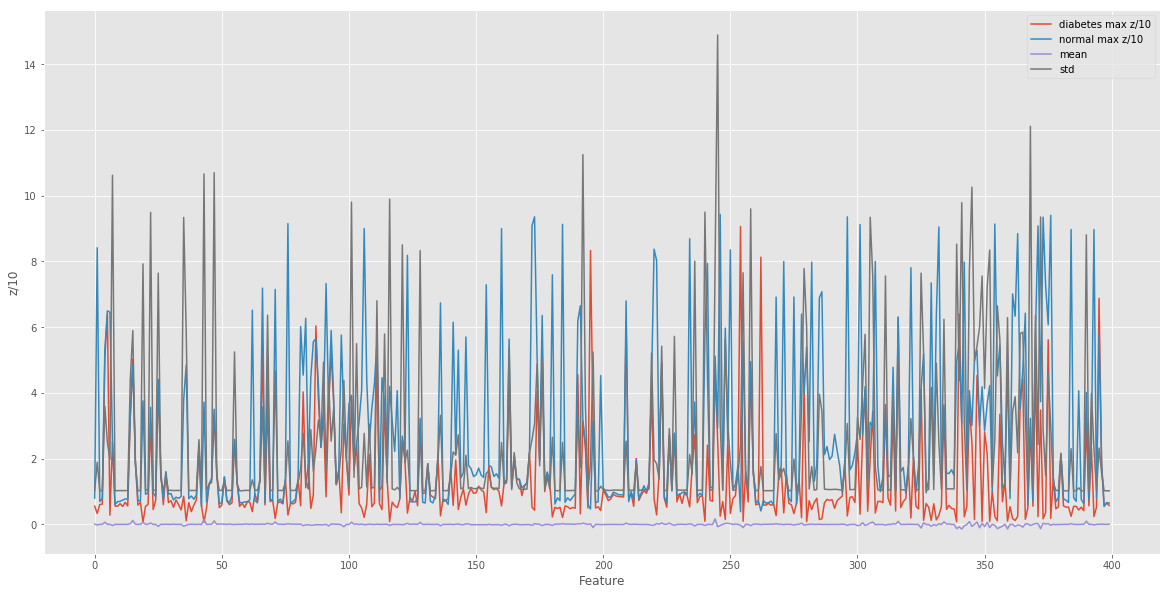

In [27]:
plot_cols = data_cols
plt.figure(figsize=(20,10))
# plt.plot( np.log10( data[ plot_cols ].abs().max().values ) )
# plt.plot( data[ plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10, label='max z/10' )
plt.plot( data.loc[ data[400]==1, plot_cols ].abs().max().values / data[ plot_cols ].std().values/10 , label='diabetes max z/10' )
plt.plot( data.loc[ data[400]==0, plot_cols ].abs().max().values / data[ plot_cols ].std().values/10 , label='normal max z/10' )
plt.plot( data[ plot_cols ].mean().values, label='mean' )
# plt.plot( data[ plot_cols ].abs().mean().values, label='abs mean' )
plt.plot( data[ plot_cols ].std().values, label='std' )
plt.xlabel('Feature')
plt.ylabel('z/10')

plt.legend() ; 

In [28]:
data.groupby(400)[400].count()

400
0    7625
1    2377
Name: 400, dtype: int64

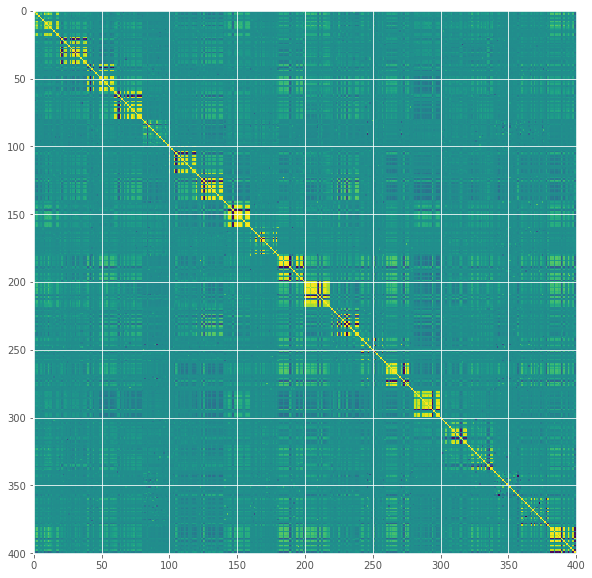

In [29]:
corr0 = data.corr()
plt.figure(figsize=(10,10))
plt.imshow(corr0) ;

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


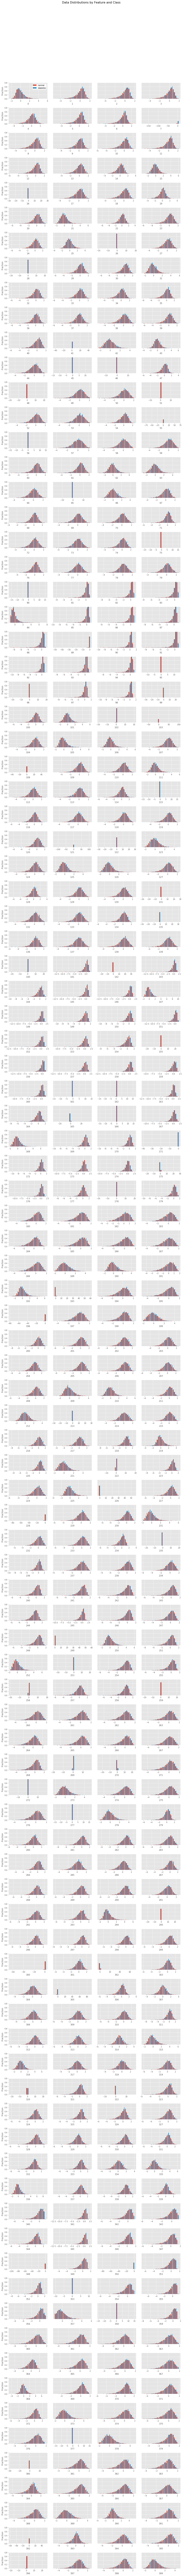

In [30]:
# Plot the data by each feature

axarr = [[]]*len(data_cols)
columns = 4
rows = int( np.ceil( len(data_cols) / columns ) )
f, fig = plt.subplots( figsize=(columns*3.5, rows*2) )

f.suptitle('Data Distributions by Feature and Class', size=16)

for i, col in enumerate(data_cols[:]):
    axarr[i] = plt.subplot2grid( (int(rows), int(columns)), (int(i//columns), int(i%columns)) )
    axarr[i].hist( [ data.loc[ data[400] == 0, col ], data.loc[ data[400] == 1, col ] ], label=['normal','diabetes'], 
                          bins=np.linspace( np.percentile(data[col],0.1), np.percentile(data[col],99.9), 30 ),
                          normed=True )
    axarr[i].set_xlabel(col, size=12)
    axarr[i].set_ylim([0,0.8])
    axarr[i].tick_params(axis='both', labelsize=10)
    if i == 0: 
        legend = axarr[i].legend()
        legend.get_frame().set_facecolor('white')
    if i%4 != 0 : 
        axarr[i].tick_params(axis='y', left='off', labelleft='off')
    else:
        axarr[i].set_ylabel('Fraction',size=12)

plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
plt.savefig('Data_Distributions.png')
plt.show()

In [31]:
pickle.dump(data, open('data/' + 'diabetes2.engineered.pkl','wb'))

In [32]:
test_cols = data.columns

# test_cols = data.columns[ data.columns != 'Amount' ]

print(len(test_cols))
print(test_cols)

401
Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            391, 392, 393, 394, 395, 396, 397, 398, 399, 400],
           dtype='int64', length=401)


<h2>Try classification with XGBoost</h2>

In [33]:
# Define some custom metric functions for use with the xgboost algorithm
# https://github.com/dmlc/xgboost/blob/master/demo/guide-python/custom_objective.py

from sklearn.metrics import recall_score, precision_score, roc_auc_score

def recall(preds, dtrain):
    labels = dtrain.get_label()
    return 'recall',  recall_score(labels, np.round(preds))

def precision(preds, dtrain):
    labels = dtrain.get_label()
    return 'precision',  precision_score(labels, np.round(preds))

def roc_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'roc_auc',  roc_auc_score(labels, preds)

In [34]:
np.random.seed(42)

n_normal = np.sum(data[400]==0) # 2981
n_diabetes = np.sum(data[400]==1) # 940
train_fraction = 0.7
fn_normal = int(n_normal * train_fraction)
fn_diabetes = int(n_diabetes * train_fraction)

normal_samples = data.loc[ data[400]==0, test_cols].sample(n_normal, replace=False).reset_index(drop=True)
diabetes_samples = data.loc[ data[400]==1, test_cols].sample(n_diabetes, replace=False).reset_index(drop=True)

train_df = pd.concat([normal_samples[:fn_normal],diabetes_samples[:fn_diabetes]],axis=0,ignore_index=True).reset_index(drop=True)
# train_df = pd.concat([real_samples[:fn_test],test_samples[:fn_test]],axis=0,ignore_index=True).reset_index(drop=True)

test_df = pd.concat([normal_samples[fn_normal:],diabetes_samples[fn_diabetes:]],axis=0,ignore_index=True).reset_index(drop=True)
print( 'classes 0, 1: ', n_normal, n_diabetes )
print( 'train, test: ', len(train_df), len(test_df) )

X_col = test_df.columns[:-1]
y_col = test_df.columns[-1]
dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col])
dtest = xgb.DMatrix(test_df[X_col], test_df[y_col])


classes 0, 1:  7625 2377
train, test:  7000 3002


In [35]:
def BaseMetrics(y_pred,y_true):
    TP = np.sum( (y_pred == 1) & (y_true == 1) )
    TN = np.sum( (y_pred == 0) & (y_true == 0) )
    FP = np.sum( (y_pred == 1) & (y_true == 0) )
    FN = np.sum( (y_pred == 0) & (y_true == 1) )
    return TP, TN, FP, FN

def SimpleMetrics(y_pred,y_true):
    TP, TN, FP, FN = BaseMetrics(y_pred,y_true)
    ACC = ( TP + TN ) / ( TP + TN + FP + FN )
    
    # Reporting
    from IPython.display import display
    print( 'Confusion Matrix')
    display( pd.DataFrame( [[TN,FP],[FN,TP]], columns=['Pred 0','Pred 1'], index=['True 0', 'True 1'] ) )
    print( 'Accuracy : {}'.format( ACC ))
    
def SimpleAccuracy(y_pred,y_true):
    TP, TN, FP, FN = BaseMetrics(y_pred,y_true)
    ACC = ( TP + TN ) / ( TP + TN + FP + FN )
    return ACC

In [36]:

# Run the xgboost algorithm, maximize recall on the test set

results_dict = {}

xgb_params = {
#     'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # auc, error
#     'tree_method': 'hist'
#     'grow_policy': 'lossguide' # depthwise, lossguide
}

xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=3000, 
                     verbose_eval=False,
                     early_stopping_rounds=50, 
                     evals=[(dtrain,'train'),(dtest,'test')],
                     evals_result = results_dict,              
                     feval = recall, maximize=True
#                      feval = roc_auc, maximize=True
                    )

y_pred = xgb_test.predict(dtest, ntree_limit=xgb_test.best_iteration+1)
y_true = test_df[400].values
print( 'best iteration: ', xgb_test.best_iteration )
print( recall( y_pred, dtest ) )
print( precision( y_pred, dtest ) )
print( roc_auc( y_pred, dtest ) )
# print( 'Accuracy: {:.3f}'.format(SimpleAccuracy(y_pred, y_true)) )
SimpleMetrics( np.round(y_pred), y_true)

[00:10:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[00:10:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[00:10:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[00:10:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[00:10:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[00:10:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[00:10:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[00:10:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[00:10:36] /work

[00:10:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[00:10:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[00:10:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[00:10:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[00:10:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[00:10:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[00:10:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[00:10:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[00:10:42] /wo

[00:10:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[00:10:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[00:10:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[00:10:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[00:10:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[00:10:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[00:10:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[00:10:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[00:10:47] /work

Pred 0  Pred 1
True 0    2187     101
True 1     553     161

Accuracy : 0.782145236508994


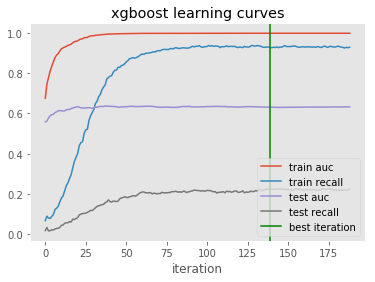

In [37]:
for i in results_dict:
    for err in results_dict[i]:
        plt.plot(results_dict[i][err], label=i+' '+err)   
plt.axvline(xgb_test.best_iteration, c='green', label='best iteration')
plt.xlabel('iteration')
# plt.ylabel(err)
plt.title('xgboost learning curves')
plt.legend()
plt.grid() ;

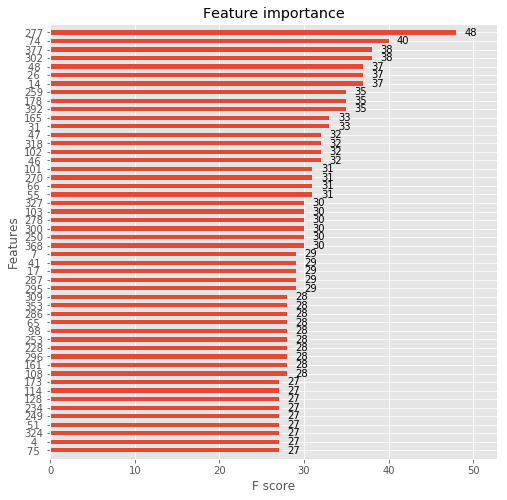

In [38]:
# Plot feature importances

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
xgb.plot_importance(xgb_test, max_num_features=50, height=0.5, ax=ax);

In [39]:
import operator
x = xgb_test.get_fscore()
sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)

# print( 'Top eight features for fraud detection: ', [ i[0] for i in sorted_x[:8] ] )

sorted_cols = [i[0] for i in sorted_x] + ['Class']
print( sorted_cols )

['277', '74 ', '302', '377', '14 ', '26 ', '48 ', '392', '178', '259', '31 ', '165', '46 ', '102', '318', '47 ', '55 ', '66 ', '270', '101', '368', '250', '300', '278', '103', '327', '295', '287', '17 ', '41 ', '7  ', '108', '161', '296', '228', '253', '98 ', '65 ', '286', '353', '309', '75 ', '4  ', '324', '51 ', '249', '234', '128', '114', '173', '154', '35 ', '121', '258', '334', '184', '25 ', '384', '131', '61 ', '45 ', '116', '162', '280', '123', '226', '272', '322', '15 ', '303', '308', '222', '369', '32 ', '304', '192', '204', '358', '235', '6  ', '372', '348', '279', '19 ', '331', '244', '336', '225', '219', '122', '315', '112', '90 ', '285', '307', '22 ', '196', '163', '67 ', '332', '125', '43 ', '127', '305', '28 ', '240', '135', '58 ', '118', '264', '166', '213', '326', '210', '335', '323', '306', '328', '338', '42 ', '268', '175', '316', '56 ', '349', '236', '282', '339', '117', '97 ', '269', '283', '167', '16 ', '124', '390', '106', '38 ', '110', '190', '325', '329', '319'

<h1>Classification using NN</h1>

In [40]:
np.random.seed(42)

n_normal = np.sum(data[400]==0) # 2981
n_diabetes = np.sum(data[400]==1) # 940
train_fraction = 0.8
fn_normal = int(n_normal * train_fraction)
fn_diabetes = int(n_diabetes * train_fraction)

normal_samples = data.loc[ data[400]==0, test_cols].sample(n_normal, replace=False).reset_index(drop=True)
diabetes_samples = data.loc[ data[400]==1, test_cols].sample(n_diabetes, replace=False).reset_index(drop=True)

train_df = pd.concat([normal_samples[:fn_normal],diabetes_samples[:fn_diabetes]],axis=0,ignore_index=True).reset_index(drop=True)
# train_df = pd.concat([real_samples[:fn_test],test_samples[:fn_test]],axis=0,ignore_index=True).reset_index(drop=True)

test_df = pd.concat([normal_samples[fn_normal:],diabetes_samples[fn_diabetes:]],axis=0,ignore_index=True).reset_index(drop=True)
print( 'classes 0, 1: ', n_normal, n_diabetes )
print( 'train, test: ', len(train_df), len(test_df) )
print(train_df.shape[1])

classes 0, 1:  7625 2377
train, test:  8001 2001
401


In [41]:
print(train_df.values[:,:399].shape)
X_train = train_df.values[:,:400]
y_train = train_df.values[:,400]
X_test = test_df.values[:,:400]
y_test = test_df.values[:,400]

(8001, 399)


In [42]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [43]:
from keras import layers
from keras import models
from keras import optimizers
import tensorflow as tf
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

Using TensorFlow backend.


In [46]:
inputs = layers.Input((train_df.shape[1]-1,))
base_n_count = 128
#activation = layers.ELU()
#activation.__name__ = 'ELU'
#x = layers.Dropout(0.3)(x)
x = layers.Dense(base_n_count, activation='relu')(inputs)
x = layers.Dropout(0.3)(x)
x = layers.Dense(base_n_count*4, activation='relu')(x)
#x = layers.Dropout(0.3)(x)
#x = layers.Dense(base_n_count*8, activation='relu')(x)
#x = layers.Dense(base_n_count*4, activation='relu')(x)
#x = layers.Dense(base_n_count*2, activation='relu')(x)
#x = layers.Dropout(0.2)(x)
#x = layers.Dense(base_n_count, activation='relu')(x)
x = layers.Dense(1, activation='sigmoid')(x)
#x = layers.Dense(1)(x)
classify_model = models.Model(inputs=[inputs], outputs=[x], name='classification_model')
adadelta = optimizers.Adadelta(lr=1, rho=0.95, epsilon=None, decay=0.01)
classify_model.compile(optimizer=adadelta, loss='binary_crossentropy', metrics=[auc])
classify_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 400)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               51328     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 117,889
Trainable params: 117,889
Non-trainable params: 0
_________________________________________________________________


In [47]:
#classify_model = models.load_model('model-nn.h5', custom_objects={'auc': auc})

earlystopper = EarlyStopping(patience=25, verbose=1)
checkpointer = ModelCheckpoint('model-nn-5.h5', verbose=1, save_best_only=True)

results = classify_model.fit(X_train, y_train, validation_split=0.2, batch_size=32, epochs=300, 
                    callbacks=[earlystopper, checkpointer])

Train on 6400 samples, validate on 1601 samples
Epoch 1/300
6400/6400 [==============================] - 1s 171us/step - loss: 0.6516 - auc: 0.5291 - val_loss: 0.5914 - val_auc: 0.5439

Epoch 00001: val_loss improved from inf to 0.59140, saving model to model-nn-5.h5
Epoch 2/300
6400/6400 [==============================] - 1s 127us/step - loss: 0.5734 - auc: 0.5614 - val_loss: 0.5931 - val_auc: 0.5706

Epoch 00002: val_loss did not improve from 0.59140
Epoch 3/300
6400/6400 [==============================] - 1s 127us/step - loss: 0.5586 - auc: 0.5792 - val_loss: 0.5913 - val_auc: 0.5859

Epoch 00003: val_loss improved from 0.59140 to 0.59132, saving model to model-nn-5.h5
Epoch 4/300
6400/6400 [==============================] - 1s 158us/step - loss: 0.5344 - auc: 0.5936 - val_loss: 0.5887 - val_auc: 0.6004

Epoch 00004: val_loss improved from 0.59132 to 0.58870, saving model to model-nn-5.h5
Epoch 5/300
6400/6400 [==============================] - 1s 124us/step - loss: 0.5436 - auc: 0.

In [51]:
print(results.history.keys())

dict_keys(['val_loss', 'val_auc', 'loss', 'auc'])


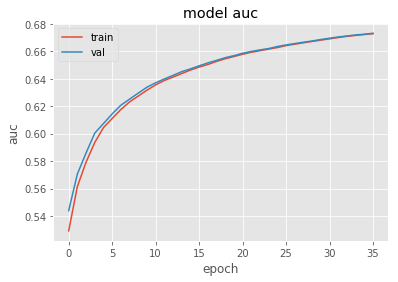

In [52]:
plt.plot(results.history['auc'])
plt.plot(results.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

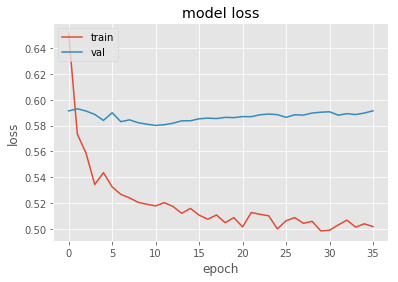

In [53]:
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [54]:
model = models.load_model('model-nn-5.h5', custom_objects={'auc': auc})

In [55]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

2001/2001 [==============================] - 0s 24us/step


In [56]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


print(np.mean(preds_train_t == y_train[:int(y_train.shape[0]*0.9)]))
print(np.mean(preds_val_t == y_train[int(y_train.shape[0]*0.9):]))
print(np.mean(preds_test_t == y_test))

0.7524241898148148
0.7611038636161727
0.7526873744537027


In [57]:
def BaseMetrics(y_pred,y_true):
    CM = confusion_matrix(y_true, y_pred)

    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    return TP, TN, FP, FN

In [58]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
fpr, tpr, thresholds = roc_curve(y_test, preds_test)
auc_test = auc(fpr, tpr)
print(auc_test)

fpr_train, tpr_train, thresholds_train = roc_curve(y_train[:int(y_train.shape[0]*0.9)], preds_train)
auc_train = auc(fpr_train, tpr_train)
print(auc_train)
TP, TN, FP, FN = BaseMetrics(preds_test_t, y_test)
print("precision =", TP/(TP+FP))
print("recall = ", TP/(TP+FN))
print(np.sum((preds_test_t == 0) & (y_test == 1)))

0.5896569775451164
0.7315535345535531
precision = 0.3333333333333333
recall =  0.025210084033613446
935340


In [59]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0.0: 1525, 1.0: 476}

In [60]:
unique, counts = np.unique(preds_test_t, return_counts=True)
dict(zip(unique, counts))

{0: 1965, 1: 36}

<h2>Prepare for GAN</h2>

In [94]:
# reloading the libraries and setting the parameters
import gan
import importlib
importlib.reload(gan) # For reloading after making changes
from gan import *

rand_dim = 400 # 32 # needs to be ~data_dim
base_n_count = 128 # 128

In [95]:
nb_steps = 5000 + 1 # 50000 # Add one for logging of the last interval
batch_size = 64 # 64

k_d = 1  # number of critic network updates per adversarial training step
k_g = 1  # number of generator network updates per adversarial training step
critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
learning_rate = 0.1 # using Adadelta optimizer
data_dir = 'cache/'
generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None

# show = False
show = True 

# train = create_toy_spiral_df(1000)
# train = create_toy_df(n=1000,n_dim=2,n_classes=4,seed=0)
train = data.copy().reset_index(drop=True) # fraud only with labels from classification

# train = pd.get_dummies(train, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [ 400 ]
data_cols = [ i for i in range(0, 400) ]
train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train[ data_cols ]

data_dim:  400
data_cols:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 21

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_93 (InputLayer)        (None, 400)               0         
_________________________________________________________________
dense_272 (Dense)            (None, 128)               51328     
_________________________________________________________________
dropout_78 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_273 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_274 (Dense)            (None, 1)                 513       
Total params: 117,889
Trainable params: 117,889
Non-trainable params: 0
_________________________________________________________________
Train on 2138 samples, validate on 238 samples
Epoch 1/10
2138/2138 [==============================] - 6s 3ms/step - loss: 0.6197 - auc:

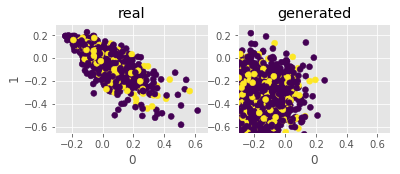

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_94 (InputLayer)        (None, 400)               0         
_________________________________________________________________
dense_275 (Dense)            (None, 128)               51328     
_________________________________________________________________
dropout_79 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_276 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_277 (Dense)            (None, 1)                 513       
Total params: 117,889
Trainable params: 117,889
Non-trainable params: 0
_________________________________________________________________
Train on 2138 samples, validate on 238 samples
Epoch 1/10
2138/2138 [==============================] - 6s 3ms/step - loss: 0.6513 - auc:

2138/2138 [==============================] - 0s 227us/step - loss: 0.5778 - auc: 0.5012 - val_loss: 0.5793 - val_auc: 0.5023

Epoch 00003: val_loss did not improve from 0.57288
Epoch 4/10
2138/2138 [==============================] - 1s 264us/step - loss: 0.5729 - auc: 0.5038 - val_loss: 0.5809 - val_auc: 0.5070

Epoch 00004: val_loss did not improve from 0.57288
Epoch 5/10
2138/2138 [==============================] - 1s 273us/step - loss: 0.5696 - auc: 0.5089 - val_loss: 0.5801 - val_auc: 0.5100

Epoch 00005: val_loss did not improve from 0.57288
Epoch 6/10
2138/2138 [==============================] - 1s 241us/step - loss: 0.5666 - auc: 0.5118 - val_loss: 0.5799 - val_auc: 0.5127

Epoch 00006: val_loss did not improve from 0.57288
Epoch 7/10
2138/2138 [==============================] - 1s 253us/step - loss: 0.5643 - auc: 0.5153 - val_loss: 0.5793 - val_auc: 0.5148

Epoch 00007: val_loss did not improve from 0.57288
Epoch 8/10
2138/2138 [==============================] - 1s 252us/step -

2378/2378 [==============================] - 0s 119us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_99 (InputLayer)        (None, 400)               0         
_________________________________________________________________
dense_290 (Dense)            (None, 128)               51328     
_________________________________________________________________
dropout_84 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_291 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_292 (Dense)            (None, 1)                 513       
Total params: 117,889
Trainable params: 117,889
Non-trainable params: 0
_________________________________________________________________
Train on 2138 samples, validate on 238 samples
Epoch 1/10
2138/2138 [========

2138/2138 [==============================] - 0s 193us/step - loss: 0.6028 - auc: 0.5102 - val_loss: 0.5193 - val_auc: 0.5085

Epoch 00002: val_loss improved from 0.52570 to 0.51932, saving model to model-nn-classify.h5
Epoch 3/10
2138/2138 [==============================] - 0s 194us/step - loss: 0.5967 - auc: 0.5096 - val_loss: 0.5175 - val_auc: 0.5096

Epoch 00003: val_loss improved from 0.51932 to 0.51748, saving model to model-nn-classify.h5
Epoch 4/10
2138/2138 [==============================] - 0s 196us/step - loss: 0.5927 - auc: 0.5139 - val_loss: 0.5174 - val_auc: 0.5107

Epoch 00004: val_loss improved from 0.51748 to 0.51735, saving model to model-nn-classify.h5
Epoch 5/10
2138/2138 [==============================] - 0s 193us/step - loss: 0.5896 - auc: 0.5113 - val_loss: 0.5161 - val_auc: 0.5122

Epoch 00005: val_loss improved from 0.51735 to 0.51612, saving model to model-nn-classify.h5
Epoch 6/10
2138/2138 [==============================] - 0s 195us/step - loss: 0.5872 - auc:

Epoch 9/10
2138/2138 [==============================] - 1s 323us/step - loss: 0.5883 - auc: 0.5157 - val_loss: 0.5272 - val_auc: 0.5164

Epoch 00009: val_loss improved from 0.52724 to 0.52716, saving model to model-nn-classify.h5
Epoch 10/10
2138/2138 [==============================] - 1s 304us/step - loss: 0.5868 - auc: 0.5170 - val_loss: 0.5270 - val_auc: 0.5176

Epoch 00010: val_loss improved from 0.52716 to 0.52698, saving model to model-nn-classify.h5
2378/2378 [==============================] - 0s 182us/step
Step: 100 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.6422, 0.7486, 0.6525, 0.7670
D Real - D Gen: -0.0962


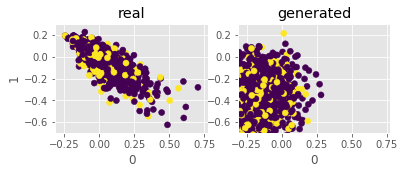

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_104 (InputLayer)       (None, 400)               0         
_________________________________________________________________
dense_305 (Dense)            (None, 128)               51328     
_________________________________________________________________
dropout_89 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_306 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_307 (Dense)            (None, 1)                 513       
Total params: 117,889
Trainable params: 117,889
Non-trainable params: 0
_________________________________________________________________
Train on 2138 samples, validate on 238 samples
Epoch 1/10
2138/2138 [==============================] - 7s 3ms/step - loss: 0.6064 - auc:


Epoch 00001: val_loss improved from inf to 0.52269, saving model to model-nn-classify.h5
Epoch 2/10
2138/2138 [==============================] - 0s 225us/step - loss: 0.6063 - auc: 0.5031 - val_loss: 0.5114 - val_auc: 0.5032

Epoch 00002: val_loss improved from 0.52269 to 0.51145, saving model to model-nn-classify.h5
Epoch 3/10
2138/2138 [==============================] - 0s 214us/step - loss: 0.5995 - auc: 0.5051 - val_loss: 0.5085 - val_auc: 0.5066

Epoch 00003: val_loss improved from 0.51145 to 0.50851, saving model to model-nn-classify.h5
Epoch 4/10
2138/2138 [==============================] - 1s 264us/step - loss: 0.5952 - auc: 0.5078 - val_loss: 0.5076 - val_auc: 0.5094

Epoch 00004: val_loss improved from 0.50851 to 0.50758, saving model to model-nn-classify.h5
Epoch 5/10
2138/2138 [==============================] - 1s 281us/step - loss: 0.5920 - auc: 0.5102 - val_loss: 0.5073 - val_auc: 0.5115

Epoch 00005: val_loss improved from 0.50758 to 0.50729, saving model to model-nn-cl

2138/2138 [==============================] - 1s 321us/step - loss: 0.5678 - auc: 0.5198 - val_loss: 0.5103 - val_auc: 0.5196

Epoch 00008: val_loss improved from 0.51051 to 0.51027, saving model to model-nn-classify.h5
Epoch 9/10
2138/2138 [==============================] - 0s 205us/step - loss: 0.5660 - auc: 0.5205 - val_loss: 0.5100 - val_auc: 0.5211

Epoch 00009: val_loss improved from 0.51027 to 0.51002, saving model to model-nn-classify.h5
Epoch 10/10
2138/2138 [==============================] - 0s 210us/step - loss: 0.5645 - auc: 0.5215 - val_loss: 0.5098 - val_auc: 0.5224

Epoch 00010: val_loss improved from 0.51002 to 0.50980, saving model to model-nn-classify.h5
2378/2378 [==============================] - 0s 100us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_109 (InputLayer)       (None, 400)               0         
_______________________________________________________________

Train on 2138 samples, validate on 238 samples
Epoch 1/10
2138/2138 [==============================] - 8s 4ms/step - loss: 0.6331 - auc: 0.4890 - val_loss: 0.5353 - val_auc: 0.5168

Epoch 00001: val_loss improved from inf to 0.53527, saving model to model-nn-classify.h5
Epoch 2/10
2138/2138 [==============================] - 0s 232us/step - loss: 0.5958 - auc: 0.5138 - val_loss: 0.5238 - val_auc: 0.5174

Epoch 00002: val_loss improved from 0.53527 to 0.52383, saving model to model-nn-classify.h5
Epoch 3/10
2138/2138 [==============================] - 0s 232us/step - loss: 0.5891 - auc: 0.5206 - val_loss: 0.5234 - val_auc: 0.5179

Epoch 00003: val_loss improved from 0.52383 to 0.52341, saving model to model-nn-classify.h5
Epoch 4/10
2138/2138 [==============================] - 0s 209us/step - loss: 0.5845 - auc: 0.5194 - val_loss: 0.5230 - val_auc: 0.5199

Epoch 00004: val_loss improved from 0.52341 to 0.52304, saving model to model-nn-classify.h5
Epoch 5/10
2138/2138 [=================

2138/2138 [==============================] - 1s 239us/step - loss: 0.5913 - auc: 0.5201 - val_loss: 0.5605 - val_auc: 0.5209

Epoch 00008: val_loss did not improve from 0.55953
Epoch 9/10
2138/2138 [==============================] - 0s 213us/step - loss: 0.5899 - auc: 0.5219 - val_loss: 0.5607 - val_auc: 0.5219

Epoch 00009: val_loss did not improve from 0.55953
Epoch 10/10
2138/2138 [==============================] - 1s 256us/step - loss: 0.5887 - auc: 0.5225 - val_loss: 0.5608 - val_auc: 0.5229

Epoch 00010: val_loss did not improve from 0.55953
2378/2378 [==============================] - 0s 105us/step
Step: 200 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.6349, 0.7569, 0.6587, 0.7679
D Real - D Gen: -0.0982


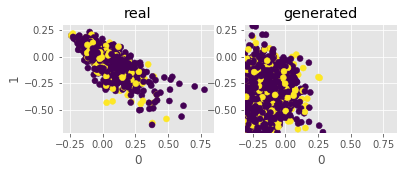

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_114 (InputLayer)       (None, 400)               0         
_________________________________________________________________
dense_335 (Dense)            (None, 128)               51328     
_________________________________________________________________
dropout_99 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_336 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_337 (Dense)            (None, 1)                 513       
Total params: 117,889
Trainable params: 117,889
Non-trainable params: 0
_________________________________________________________________
Train on 2138 samples, validate on 238 samples
Epoch 1/10
2138/2138 [==============================] - 8s 4ms/step - loss: 0.6164 - auc:

2138/2138 [==============================] - 0s 211us/step - loss: 0.5877 - auc: 0.5100 - val_loss: 0.5400 - val_auc: 0.5120

Epoch 00003: val_loss improved from 0.54020 to 0.53999, saving model to model-nn-classify.h5
Epoch 4/10
2138/2138 [==============================] - 0s 223us/step - loss: 0.5832 - auc: 0.5125 - val_loss: 0.5399 - val_auc: 0.5145

Epoch 00004: val_loss improved from 0.53999 to 0.53988, saving model to model-nn-classify.h5
Epoch 5/10
2138/2138 [==============================] - 1s 307us/step - loss: 0.5797 - auc: 0.5146 - val_loss: 0.5398 - val_auc: 0.5168

Epoch 00005: val_loss improved from 0.53988 to 0.53980, saving model to model-nn-classify.h5
Epoch 6/10
2138/2138 [==============================] - 1s 263us/step - loss: 0.5769 - auc: 0.5168 - val_loss: 0.5397 - val_auc: 0.5187

Epoch 00006: val_loss improved from 0.53980 to 0.53970, saving model to model-nn-classify.h5
Epoch 7/10
2138/2138 [==============================] - 0s 216us/step - loss: 0.5747 - auc:

2378/2378 [==============================] - 0s 176us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_119 (InputLayer)       (None, 400)               0         
_________________________________________________________________
dense_350 (Dense)            (None, 128)               51328     
_________________________________________________________________
dropout_104 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_351 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_352 (Dense)            (None, 1)                 513       
Total params: 117,889
Trainable params: 117,889
Non-trainable params: 0
_________________________________________________________________
Train on 2138 samples, validate on 238 samples
Epoch 1/10
2138/2138 [========

Epoch 4/10
2138/2138 [==============================] - 1s 327us/step - loss: 0.5791 - auc: 0.5171 - val_loss: 0.4913 - val_auc: 0.5162

Epoch 00004: val_loss improved from 0.49201 to 0.49135, saving model to model-nn-classify.h5
Epoch 5/10
2138/2138 [==============================] - 1s 315us/step - loss: 0.5757 - auc: 0.5169 - val_loss: 0.4909 - val_auc: 0.5180

Epoch 00005: val_loss improved from 0.49135 to 0.49091, saving model to model-nn-classify.h5
Epoch 6/10
2138/2138 [==============================] - 1s 293us/step - loss: 0.5730 - auc: 0.5200 - val_loss: 0.4908 - val_auc: 0.5196

Epoch 00006: val_loss improved from 0.49091 to 0.49083, saving model to model-nn-classify.h5
Epoch 7/10
2138/2138 [==============================] - 1s 286us/step - loss: 0.5707 - auc: 0.5211 - val_loss: 0.4906 - val_auc: 0.5212

Epoch 00007: val_loss improved from 0.49083 to 0.49058, saving model to model-nn-classify.h5
Epoch 8/10
2138/2138 [==============================] - 1s 289us/step - loss: 0.

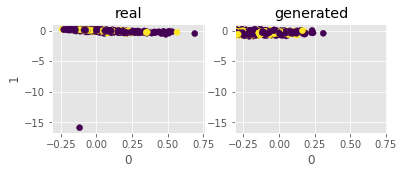

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_124 (InputLayer)       (None, 400)               0         
_________________________________________________________________
dense_365 (Dense)            (None, 128)               51328     
_________________________________________________________________
dropout_109 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_366 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_367 (Dense)            (None, 1)                 513       
Total params: 117,889
Trainable params: 117,889
Non-trainable params: 0
_________________________________________________________________
Train on 2138 samples, validate on 238 samples
Epoch 1/10
2138/2138 [==============================] - 9s 4ms/step - loss: 0.6232 - auc:

In [ ]:
# Training the vanilla GAN and CGAN architectures

k_d = 1  # number of critic network updates per adversarial training step
learning_rate = 5e-4 # 5e-5
arguments = [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

#adversarial_training_GAN(arguments, train_no_label, data_cols ) # GAN
adversarial_training_GAN(arguments, train, data_cols=data_cols, label_cols=label_cols ) # CGAN

data_dim:  400
data_cols:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 21

846/846 [==============================] - 0s 248us/step - loss: 0.6154 - auc: 0.5102 - val_loss: 0.5513 - val_auc: 0.5081

Epoch 00002: val_loss improved from 0.59801 to 0.55129, saving model to model-nn-classify.h5
Epoch 3/10
846/846 [==============================] - 0s 246us/step - loss: 0.5936 - auc: 0.5119 - val_loss: 0.5360 - val_auc: 0.5146

Epoch 00003: val_loss improved from 0.55129 to 0.53603, saving model to model-nn-classify.h5
Epoch 4/10
846/846 [==============================] - 0s 218us/step - loss: 0.5843 - auc: 0.5153 - val_loss: 0.5318 - val_auc: 0.5179

Epoch 00004: val_loss improved from 0.53603 to 0.53182, saving model to model-nn-classify.h5
Epoch 5/10
846/846 [==============================] - 0s 212us/step - loss: 0.5793 - auc: 0.5185 - val_loss: 0.5305 - val_auc: 0.5202

Epoch 00005: val_loss improved from 0.53182 to 0.53053, saving model to model-nn-classify.h5
Epoch 6/10
846/846 [==============================] - 0s 225us/step - loss: 0.5754 - auc: 0.5209 - 

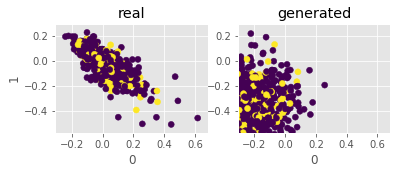

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_80 (InputLayer)        (None, 400)               0         
_________________________________________________________________
dense_234 (Dense)            (None, 128)               51328     
_________________________________________________________________
dropout_68 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_235 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_236 (Dense)            (None, 1)                 513       
Total params: 117,889
Trainable params: 117,889
Non-trainable params: 0
_________________________________________________________________
Train on 846 samples, validate on 94 samples
Epoch 1/10
846/846 [==============================] - 5s 6ms/step - loss: 0.6700 - auc: 0.5

846/846 [==============================] - 0s 259us/step - loss: 0.5635 - auc: 0.4959 - val_loss: 0.5398 - val_auc: 0.4975

Epoch 00005: val_loss did not improve from 0.53859
Epoch 6/10
846/846 [==============================] - 0s 238us/step - loss: 0.5598 - auc: 0.4981 - val_loss: 0.5406 - val_auc: 0.4998

Epoch 00006: val_loss did not improve from 0.53859
Epoch 7/10
846/846 [==============================] - 0s 249us/step - loss: 0.5565 - auc: 0.4986 - val_loss: 0.5411 - val_auc: 0.5018

Epoch 00007: val_loss did not improve from 0.53859
Epoch 8/10
846/846 [==============================] - 0s 256us/step - loss: 0.5536 - auc: 0.5035 - val_loss: 0.5415 - val_auc: 0.5038

Epoch 00008: val_loss did not improve from 0.53859
Epoch 9/10
846/846 [==============================] - 0s 245us/step - loss: 0.5509 - auc: 0.5050 - val_loss: 0.5417 - val_auc: 0.5055

Epoch 00009: val_loss did not improve from 0.53859
Epoch 10/10
846/846 [==============================] - 0s 245us/step - loss: 0.54

Train on 846 samples, validate on 94 samples
Epoch 1/10
846/846 [==============================] - 5s 6ms/step - loss: 0.6713 - auc: 0.5213 - val_loss: 0.6069 - val_auc: 0.5151

Epoch 00001: val_loss improved from inf to 0.60694, saving model to model-nn-classify.h5
Epoch 2/10
846/846 [==============================] - 0s 240us/step - loss: 0.6210 - auc: 0.5158 - val_loss: 0.5745 - val_auc: 0.5059

Epoch 00002: val_loss improved from 0.60694 to 0.57450, saving model to model-nn-classify.h5
Epoch 3/10
846/846 [==============================] - 0s 224us/step - loss: 0.6060 - auc: 0.5092 - val_loss: 0.5663 - val_auc: 0.5066

Epoch 00003: val_loss improved from 0.57450 to 0.56630, saving model to model-nn-classify.h5
Epoch 4/10
846/846 [==============================] - 0s 232us/step - loss: 0.5989 - auc: 0.5105 - val_loss: 0.5644 - val_auc: 0.5075

Epoch 00004: val_loss improved from 0.56630 to 0.56439, saving model to model-nn-classify.h5
Epoch 5/10
846/846 [=============================


Epoch 00009: val_loss did not improve from 0.59035
Epoch 10/10
846/846 [==============================] - 0s 270us/step - loss: 0.5946 - auc: 0.5092 - val_loss: 0.5918 - val_auc: 0.5100

Epoch 00010: val_loss did not improve from 0.59035
940/940 [==============================] - 0s 118us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_88 (InputLayer)        (None, 400)               0         
_________________________________________________________________
dense_258 (Dense)            (None, 128)               51328     
_________________________________________________________________
dropout_76 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_259 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_260 (Dense)            (None, 1)      

KeyboardInterrupt: 

In [93]:
# Training the WGAN and WCGAN architectures
k_d = 5 # train critic to optimal state each time
learning_rate = 1e-4 # 5e-5
arguments = [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

#adversarial_training_WGAN(arguments, train_no_label, data_cols=data_cols ) # WGAN
adversarial_training_WGAN(arguments, train, data_cols=data_cols, label_cols=label_cols ) # WCGAN

# # for continued training
'''
import gan
import importlib
importlib.reload(gan) # For reloading after making changes
from gan import *

last_step = 500
prefix = 'WCGAN'
# # data_dir = 'cache lr mix base 128 act mix 171026/'
data_dir = 'cache/'

# # Choose your learning rate
learning_rate = 1e-5 # first 10k
# # learning_rate = 1e-5 # 10-15k
# # learning_rate = 1e-6 # 15-20k

generator_model_path = data_dir + prefix + '_generator_model_weights_step_' + str(last_step) + '.h5'
discriminator_model_path = data_dir + prefix + '_discriminator_model_weights_step_' + str(last_step) + '.h5'
loss_pickle_path = data_dir + prefix + '_losses_step_' + str(last_step) + '.pkl'

nb_steps = 4000

arguments = [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
             data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

# # Choose your training algorithm
#adversarial_training_GAN(arguments, train_no_label, data_cols=data_cols, starting_step=last_step+1 ) # GAN
#adversarial_training_GAN(arguments, train, data_cols=data_cols, label_cols=label_cols, starting_step=last_step+1 ) # CGAN
#adversarial_training_WGAN(arguments, train_no_label, data_cols=data_cols, starting_step=last_step+1 ) # WGAN
adversarial_training_WGAN(arguments, train, data_cols=data_cols, label_cols=label_cols, starting_step=last_step+1 ) # WCGAN
'''

data_dim:  400
data_cols:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 21

[23:04:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[23:04:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[23:04:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[23:04:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:04:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:04:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[23:04:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[23:04:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[23:04:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_de

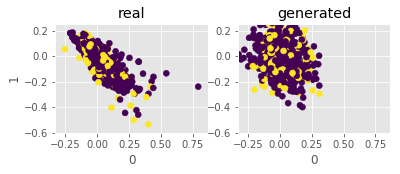

[23:04:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[23:04:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:04:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:04:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[23:04:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:04:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[23:04:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[23:04:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[23:04:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_

[23:04:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[23:04:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:04:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[23:04:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:04:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:04:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[23:04:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:04:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[23:04:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_

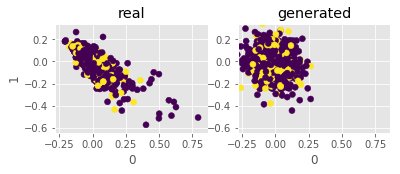

[23:04:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[23:04:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[23:04:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:04:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:04:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:04:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:04:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[23:04:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[23:04:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_

[23:04:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:04:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[23:04:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:04:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:04:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:04:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:04:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:04:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[23:04:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_

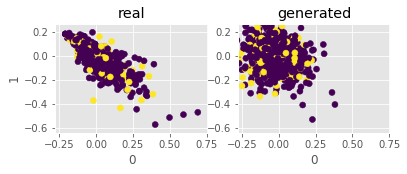

[23:04:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[23:04:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[23:04:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:04:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[23:04:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[23:04:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:04:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[23:04:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[23:04:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_de

[23:04:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:04:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:04:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:04:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:04:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[23:04:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:04:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:04:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[23:04:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

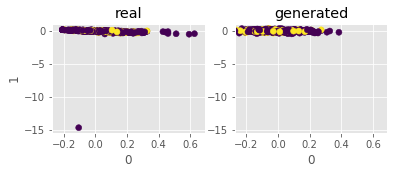

[23:04:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:04:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[23:04:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:04:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[23:04:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[23:04:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[23:04:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[23:04:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:04:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_

[23:05:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:05:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[23:05:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[23:05:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:05:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:05:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[23:05:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:05:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[23:05:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

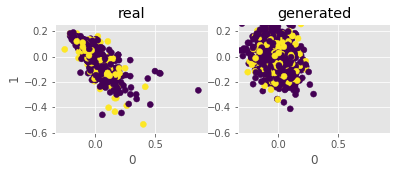

[23:05:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:05:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:05:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:05:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[23:05:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:05:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:05:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[23:05:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[23:05:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_

[23:05:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[23:05:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[23:05:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[23:05:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[23:05:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:05:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[23:05:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:05:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[23:05:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_d

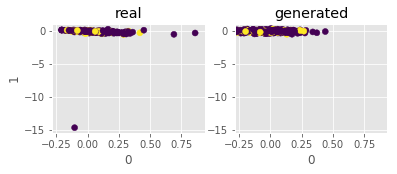

[23:05:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[23:05:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[23:05:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[23:05:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[23:05:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:05:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:05:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[23:05:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[23:05:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_

[23:05:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[23:05:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[23:05:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[23:05:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[23:05:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:05:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:05:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[23:05:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[23:05:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_

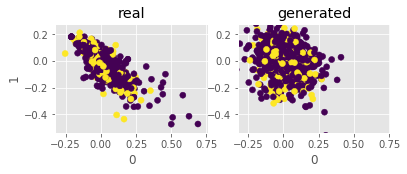

[23:05:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:05:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[23:05:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:05:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:05:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:05:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:05:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[23:05:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:05:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_

[23:05:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[23:05:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:05:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[23:05:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:05:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:05:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:05:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:05:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[23:05:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_

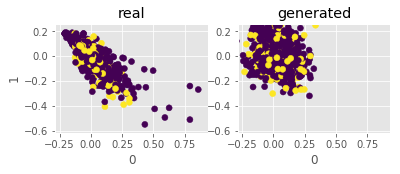

[23:05:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[23:05:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:05:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:05:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:05:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:05:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[23:05:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:05:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[23:05:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_d

[23:06:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[23:06:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:06:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[23:06:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:06:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:06:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[23:06:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:06:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[23:06:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_

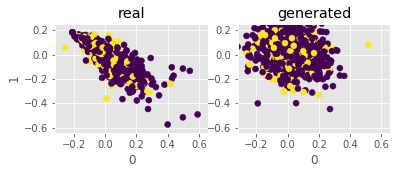

[23:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[23:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[23:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[23:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[23:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_

[23:06:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[23:06:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:06:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:06:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[23:06:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[23:06:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[23:06:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[23:06:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[23:06:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_d

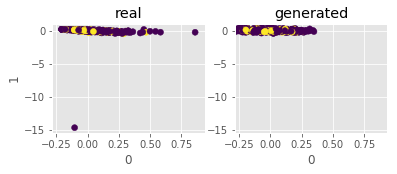

In [30]:
last_step = 500
prefix = 'WCGAN'
# # data_dir = 'cache lr mix base 128 act mix 171026/'
data_dir = 'cache/'

# # Choose your learning rate
learning_rate = 1e-5 # first 10k
# # learning_rate = 1e-5 # 10-15k
# # learning_rate = 1e-6 # 15-20k

generator_model_path = data_dir + prefix + '_generator_model_weights_step_' + str(last_step) + '.h5'
discriminator_model_path = data_dir + prefix + '_discriminator_model_weights_step_' + str(last_step) + '.h5'
loss_pickle_path = data_dir + prefix + '_losses_step_' + str(last_step) + '.pkl'

nb_steps = 1000

arguments = [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
             data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

# # Choose your training algorithm
#adversarial_training_GAN(arguments, train_no_label, data_cols=data_cols, starting_step=last_step+1 ) # GAN
#adversarial_training_GAN(arguments, train, data_cols=data_cols, label_cols=label_cols, starting_step=last_step+1 ) # CGAN
#adversarial_training_WGAN(arguments, train_no_label, data_cols=data_cols, starting_step=last_step+1 ) # WGAN
adversarial_training_WGAN(arguments, train, data_cols=data_cols, label_cols=label_cols, starting_step=last_step+1 ) # WCGAN

In [64]:

# For reloading loss data from pickles

prefix = 'WCGAN'
step = 500

[combined_loss, disc_loss_generated, disc_loss_real, classify_acc] = pickle.load(
    open(data_dir+prefix+'_losses_step_'+str(step)+'.pkl','rb'))

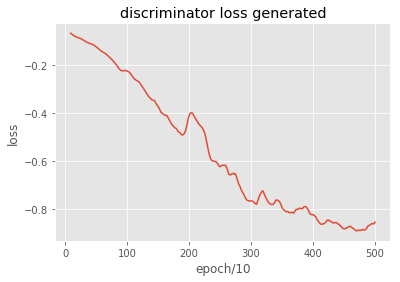

In [65]:
w = 10
plt.title('discriminator loss generated')
plt.ylabel('loss')
plt.xlabel('epoch/10')
plt.plot( pd.DataFrame(disc_loss_generated[:]).rolling(w).mean() ) ;

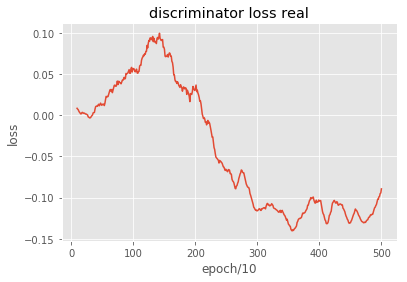

In [66]:
w = 10
plt.title('discriminator loss real')
plt.ylabel('loss')
plt.xlabel('epoch/10')
plt.plot( pd.DataFrame(disc_loss_real[:]).rolling(w).mean() ) ;

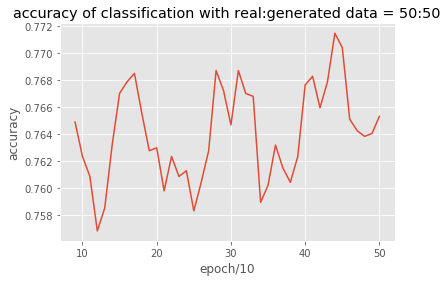

In [67]:
w = 10
plt.title('accuracy of classification with real:generated data = 50:50')
plt.ylabel('accuracy')
plt.xlabel('epoch/10')
plt.plot( pd.DataFrame(classify_acc[:]).rolling(w).mean() ) ;

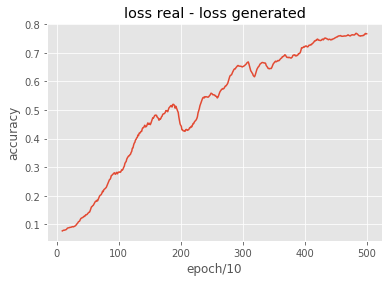

In [68]:
w = 10
plt.title('loss real - loss generated')
plt.ylabel('accuracy')
plt.xlabel('epoch/10')
plt.plot( pd.DataFrame(disc_loss_real[:]).rolling(w).mean() - pd.DataFrame(disc_loss_generated[:]).rolling(w).mean()  ) ;

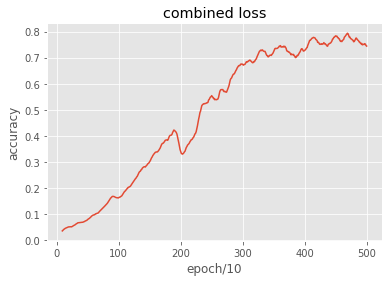

In [69]:
w = 10
plt.title('combined loss')
plt.ylabel('accuracy')
plt.xlabel('epoch/10')
plt.plot( pd.DataFrame(combined_loss[:]).rolling(w).mean() ) ;

In [70]:
# Look for the step with the highest classification accuracy, and the lowest step saved (every 100)

best_step = list(classify_acc).index( classify_acc.max() ) * 10
print( best_step, classify_acc.max() )

acc100 = [ classify_acc[i] for i in range(0, len(classify_acc), 10) ]
best_step = acc100.index( max(acc100) ) * log_interval
print( best_step, max(acc100) )

280 0.8042553191489362
500 0.7893617021276595


In [71]:
delta_losses = np.array(disc_loss_real) - np.array(disc_loss_generated)

best_step = list(delta_losses).index( delta_losses.min() )
print( best_step, delta_losses.min() )

delta100 = [ delta_losses[i] for i in range(0, len(delta_losses), 100) ]
best_step = delta100.index( min(delta100) ) * log_interval
print( best_step, min(delta100) )

1 0.06831162
0 0.071737364


In [72]:
import gan
import importlib
importlib.reload(gan) # For reloading after making changes
from gan import *

seed = 17

train = train.copy().reset_index(drop=True) # diabetes only with labels from classification

# train = pd.get_dummies(train, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [ 400 ]
data_cols = [ i for i in range(0, 400) ]
train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train[ data_cols ]

data_dim = len(data_cols)
label_dim = len(label_cols)
with_class = False
if label_dim > 0: with_class = True
np.random.seed(seed)

# define network models

# generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count, type='Wasserstein')
# generator_model.load_weights('cache/WCGAN_generator_model_weights_step_4800.h5')
generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count)
generator_model.load_weights('cache/WCGAN_generator_model_weights_step_500.h5')

In [73]:
# Now generate some new data

test_size = 3000 # Equal to all of the diabetes cases

x = get_data_batch(train, test_size, seed=1)
z = np.random.normal(size=(test_size, rand_dim))
if with_class:
    labels = x[:,-label_dim:]
    g_z = generator_model.predict([z, labels])
else:
    g_z = generator_model.predict(z)

In [74]:
train.shape
unique, counts = np.unique(x[:,400], return_counts=True)
dict(zip(unique, counts))

{0.0: 2283, 1.0: 717}

In [90]:
train.shape

(10002, 401)

In [76]:
# Plot the data by each feature
def plot_data_distribution(dataset):
    dataset = pd.DataFrame(dataset)
    axarr = [[]]*len(data_cols)
    columns = 4
    rows = int( np.ceil( len(data_cols) / columns ) )
    f, fig = plt.subplots( figsize=(columns*3.5, rows*2) )

    f.suptitle('Data Distributions by Feature and Class', size=16)

    for i, col in enumerate(data_cols[:]):
        axarr[i] = plt.subplot2grid( (int(rows), int(columns)), (int(i//columns), int(i%columns)) )
        axarr[i].hist( [ dataset.loc[ dataset[400] == 0, col ], dataset.loc[ dataset[400] == 1, col ] ], label=['normal','diabetes'], 
                              bins=np.linspace( np.percentile(dataset[col],0.1), np.percentile(dataset[col],99.9), 30 ),
                              normed=True )
        axarr[i].set_xlabel(col, size=12)
        axarr[i].set_ylim([0,0.8])
        axarr[i].tick_params(axis='both', labelsize=10)
        if i == 0: 
            legend = axarr[i].legend()
            legend.get_frame().set_facecolor('white')
        if i%4 != 0 : 
            axarr[i].tick_params(axis='y', left='off', labelleft='off')
        else:
            axarr[i].set_ylabel('Fraction',size=12)

    plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
    plt.savefig('Data_Distributions.png')
    plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


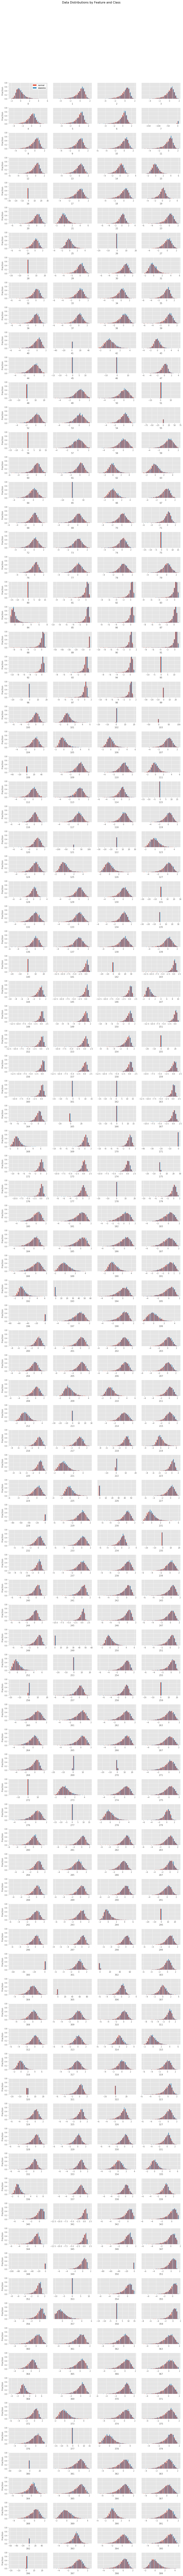

In [77]:
plot_data_distribution(data)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


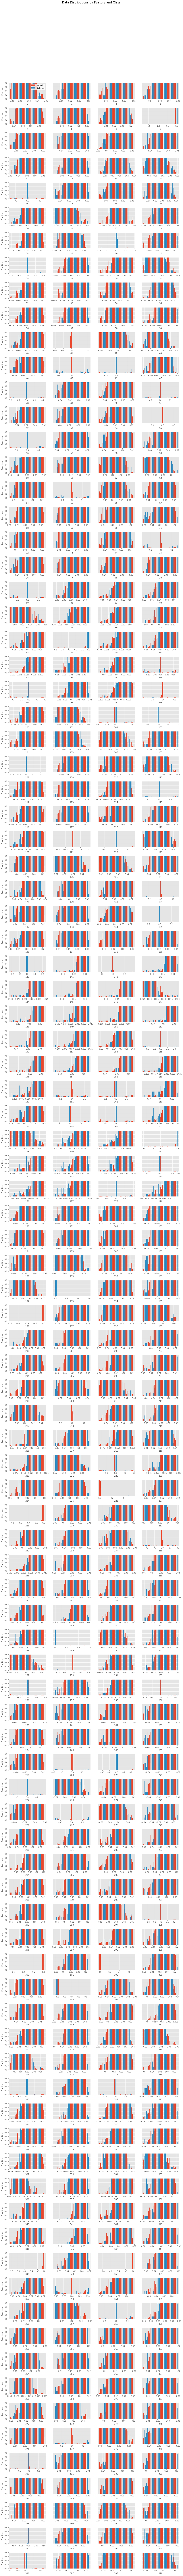

In [78]:
plot_data_distribution(train)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


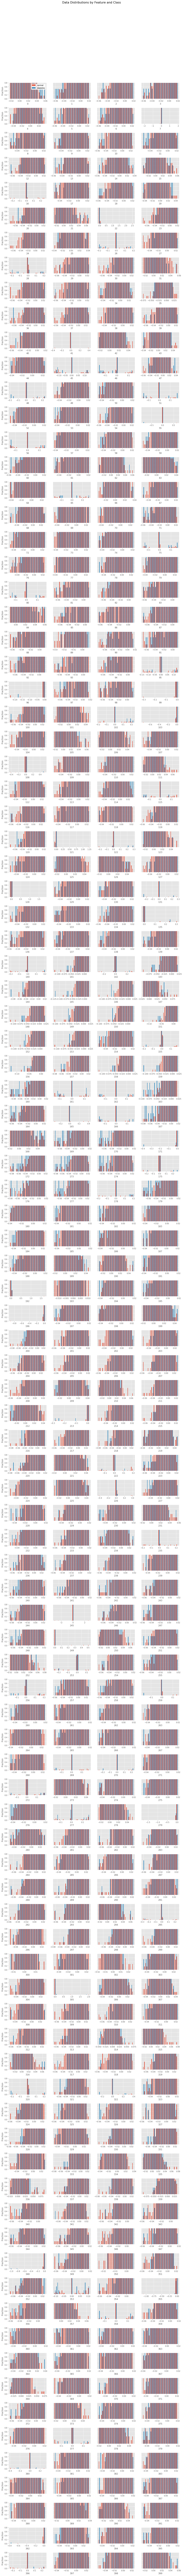

In [79]:
plot_data_distribution(x)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


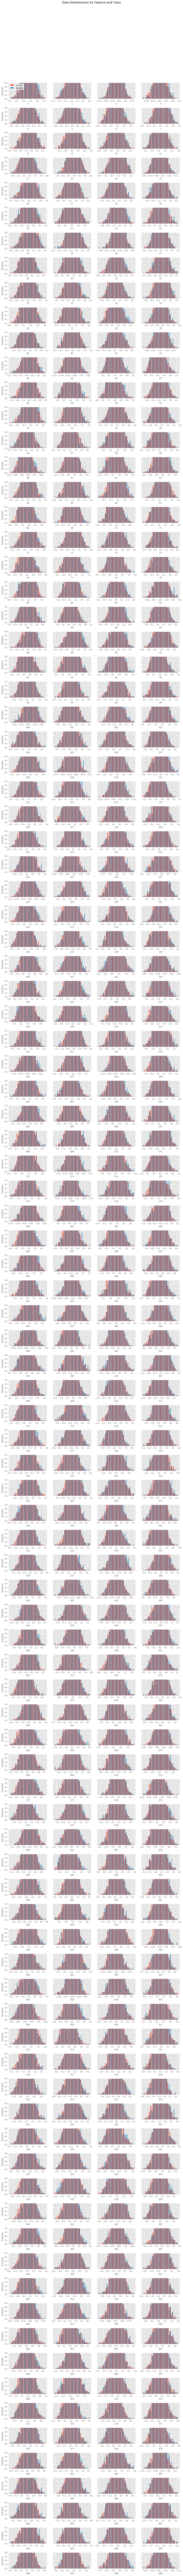

In [80]:
plot_data_distribution(g_z)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        (None, 400)               0         
_________________________________________________________________
dense_176 (Dense)            (None, 128)               51328     
_________________________________________________________________
dropout_54 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_177 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_178 (Dense)            (None, 1)                 513       
Total params: 117,889
Trainable params: 117,889
Non-trainable params: 0
_________________________________________________________________
Train on 2700 samples, validate on 300 samples
Epoch 1/10
2700/2700 [==============================] - 5s 2ms/step - loss: 0.6302 - auc:

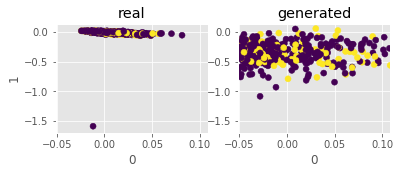

In [81]:

print( CheckAccuracy( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim ) )

PlotData( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim )

In [82]:
# Now can train and test the classifier on generated data

real_samples = pd.DataFrame(x, columns=data_cols+label_cols)
test_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
real_samples['syn_label'] = 0
test_samples['syn_label'] = 1

training_fraction = 0.5
n_real, n_test = int(len(real_samples)*training_fraction), int(len(test_samples)*training_fraction)
train_df = pd.concat([real_samples[:n_real],test_samples[:n_test]],axis=0)
test_df = pd.concat([real_samples[n_real:],test_samples[n_test:]],axis=0)

# X_col = test_df.columns[:-(label_dim+1)]
X_col = test_df.columns[:-1]
y_col = test_df.columns[-1]
#dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col])
#dtest = xgb.DMatrix(test_df[X_col])
y_true = test_df['syn_label']

base_n_count = 128
inputs = layers.Input((train_df.shape[1]-2,))
m = layers.Dense(base_n_count, activation='relu')(inputs)
m = layers.Dropout(0.3)(m)
m = layers.Dense(base_n_count*4, activation='relu')(m)
#x = layers.Dropout(0.2)(x)
#x = layers.Dense(base_n_count*8, activation='relu')(x)
#x = layers.Dense(base_n_count*4, activation='relu')(x)
#x = layers.Dense(base_n_count*2, activation='relu')(x)
#x = layers.Dropout(0.2)(x)
#x = layers.Dense(base_n_count, activation='relu')(x)
m = layers.Dense(1, activation='sigmoid')(m)
#x = layers.Dense(1)(x)
classify_model = models.Model(inputs=[inputs], outputs=[m], name='classification_model')
adadelta = optimizers.Adadelta(lr=0.1, rho=0.95, epsilon=None, decay=0.01)
classify_model.compile(optimizer=adadelta, loss='binary_crossentropy', metrics=[auc])
classify_model.summary()

earlystopper = EarlyStopping(patience=20, verbose=1)
checkpointer = ModelCheckpoint('model-nn-classify-after.h5', verbose=1, save_best_only=True)

X_train = train_df.values[:,:400]
y_train = train_df.values[:,400]
X_test = test_df.values[:,:400]
y_test = test_df.values[:,400]

results = classify_model.fit(X_train, y_train, validation_split=0.1, batch_size=32, epochs=100,
                    callbacks=[earlystopper, checkpointer])

model = models.load_model('model-nn-classify-after.h5', custom_objects={'auc': auc})

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_61 (InputLayer)        (None, 400)               0         
_________________________________________________________________
dense_179 (Dense)            (None, 128)               51328     
_________________________________________________________________
dropout_55 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_180 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_181 (Dense)            (None, 1)                 513       
Total params: 117,889
Trainable params: 117,889
Non-trainable params: 0
_________________________________________________________________
Train on 2700 samples, validate on 300 samples
Epoch 1/100
2700/2700 [==============================] - 5s 2ms/step - loss: 0.6255 - auc

In [83]:
print( '{:.2f}'.format(SimpleAccuracy(preds_train_t, y_train[:int(y_train.shape[0]*0.9)])) )
print( '{:.2f}'.format(SimpleAccuracy(preds_val_t, y_train[int(y_train.shape[0]*0.9):])) )
print( '{:.2f}'.format(SimpleAccuracy(preds_test_t, y_test)) )

0.76
0.74
0.76


In [84]:
unique, counts = np.unique(y_test[:int(y_test.shape[0]*0.9)], return_counts=True)
dict(zip(unique, counts))

{0.0: 2054, 1.0: 646}

In [85]:
unique, counts = np.unique(preds_test_t, return_counts=True)
dict(zip(unique, counts))

{0: 3000}

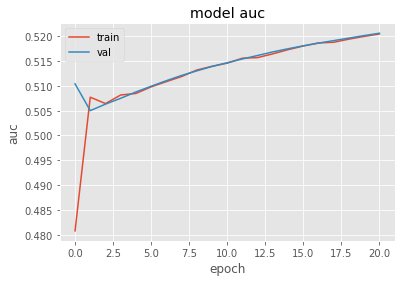

In [86]:
plt.plot(results.history['auc'])
plt.plot(results.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

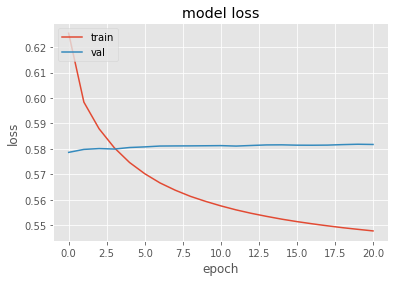

In [87]:
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [88]:
print(np.mean(preds_train_t == y_train[:int(y_train.shape[0]*0.9)]))
print(np.mean(preds_val_t == y_train[int(y_train.shape[0]*0.9):]))
print(np.mean(preds_test_t == y_test))

0.7648148148148148
0.7433333333333333
0.7593333333333333


In [89]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
fpr, tpr, thresholds = roc_curve(y_test, preds_test)
auc_test = auc(fpr, tpr)
print(auc_test)

fpr_train, tpr_train, thresholds_train = roc_curve(y_train[:int(y_train.shape[0]*0.9)], preds_train)
auc_train = auc(fpr_train, tpr_train)
print(auc_train)
TP, TN, FP, FN = BaseMetrics(preds_test_t, y_test)
print("precision =", TP/(TP+FP))
print("recall = ", TP/(TP+FN))

0.5062664314082188
0.5095071590627442
precision = nan
recall =  0.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
